In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow-io matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 6.8 MB/s eta 0:00:00


In [5]:
!pip install catboost xgboost

  Using cached catboost-1.2.3-cp310-cp310-manylinux2014_x86_64.whl (98.5 MB)


1/1 [==============================] - 3s 3s/step
Classifier: KNN (k=2)
Test Accuracy: 0.9020833333333333
Train Accuracy: 0.9740384615384615
Precision: 0.8928571428571429
Recall: 0.8968609865470852
F1 Score: 0.894854586129754
Confusion Matrix:
[[233  24]
 [ 23 200]]

Classifier: KNN (k=3)
Test Accuracy: 0.8458333333333333
Train Accuracy: 0.8966346153846154
Precision: 0.7811320754716982
Recall: 0.9282511210762332
F1 Score: 0.8483606557377049
Confusion Matrix:
[[199  58]
 [ 16 207]]

Classifier: SVM
Test Accuracy: 0.8291666666666667
Train Accuracy: 0.8350961538461539
Precision: 0.7925311203319502
Recall: 0.8565022421524664
F1 Score: 0.8232758620689655
Confusion Matrix:
[[207  50]
 [ 32 191]]

Classifier: Random Forests
Test Accuracy: 0.9395833333333333
Train Accuracy: 1.0
Precision: 0.907563025210084
Recall: 0.968609865470852
F1 Score: 0.9370932754880694
Confusion Matrix:
[[235  22]
 [  7 216]]

Classifier: Naive Bayes
Test Accuracy: 0.5333333333333333
Train Accuracy: 0.5822115384615385


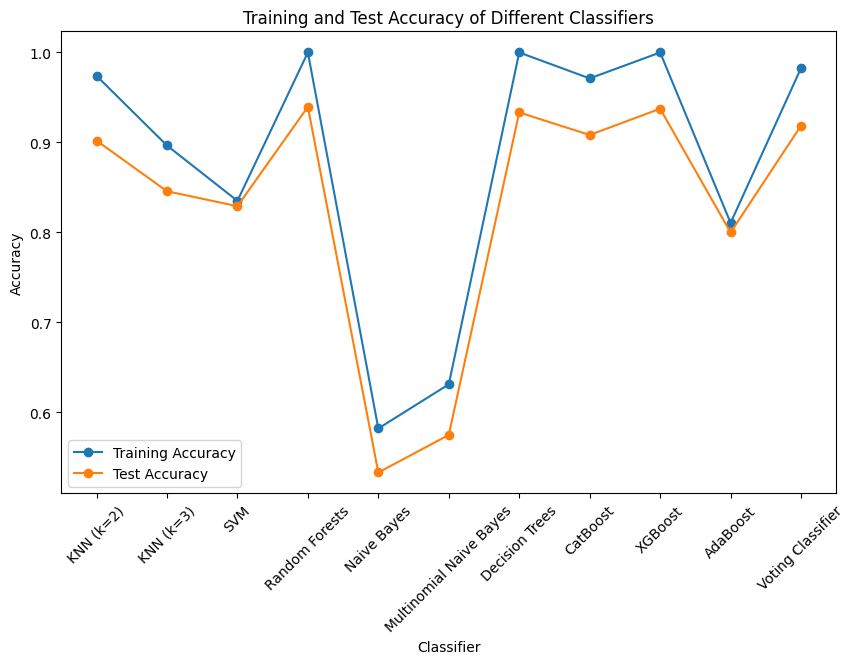

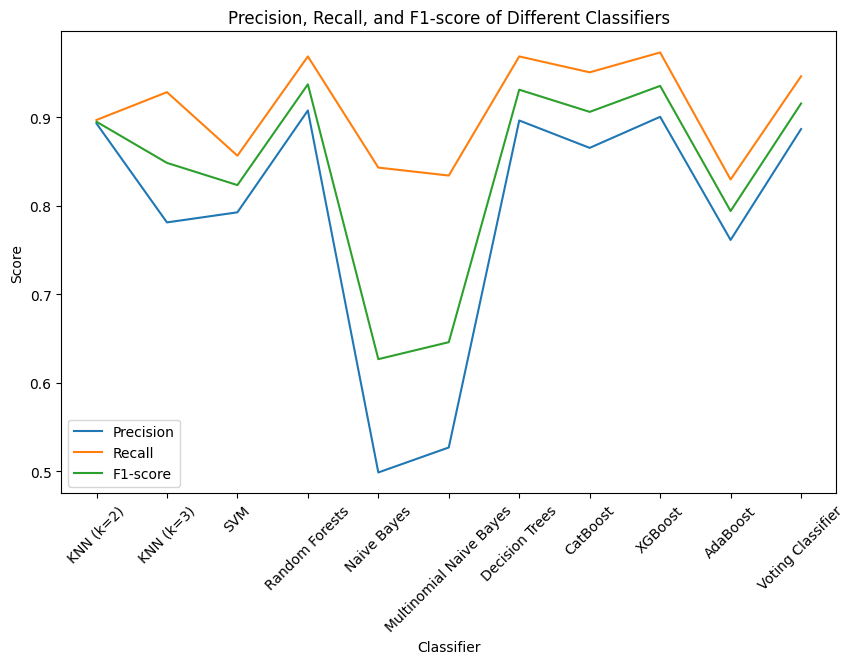

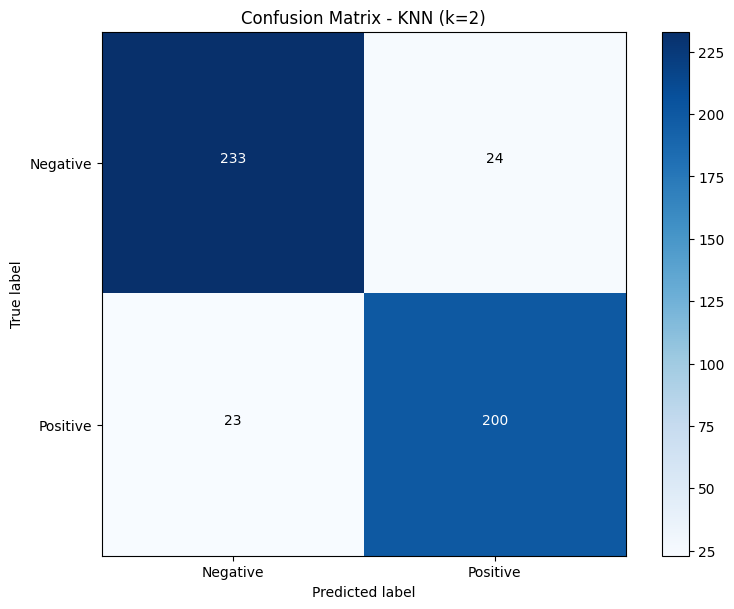

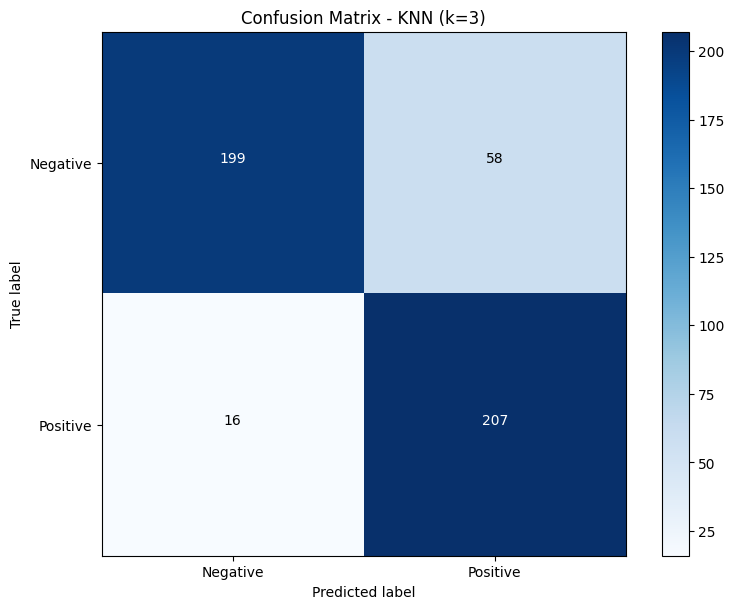

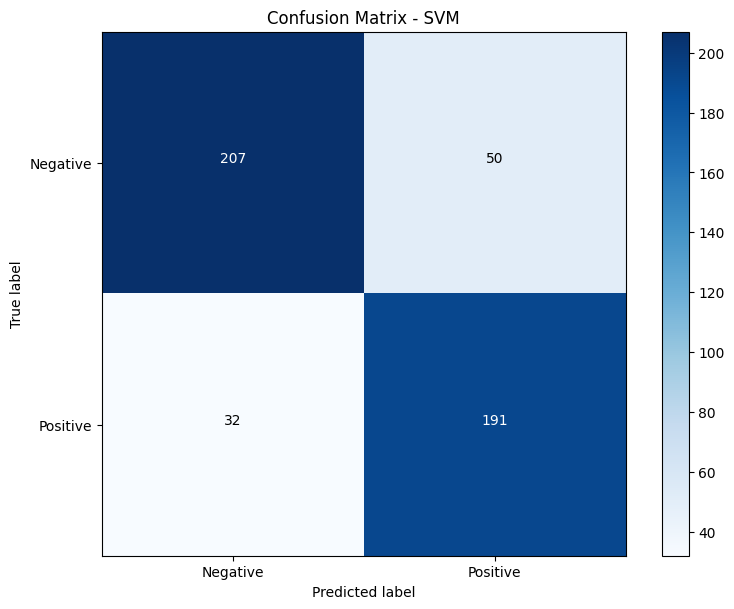

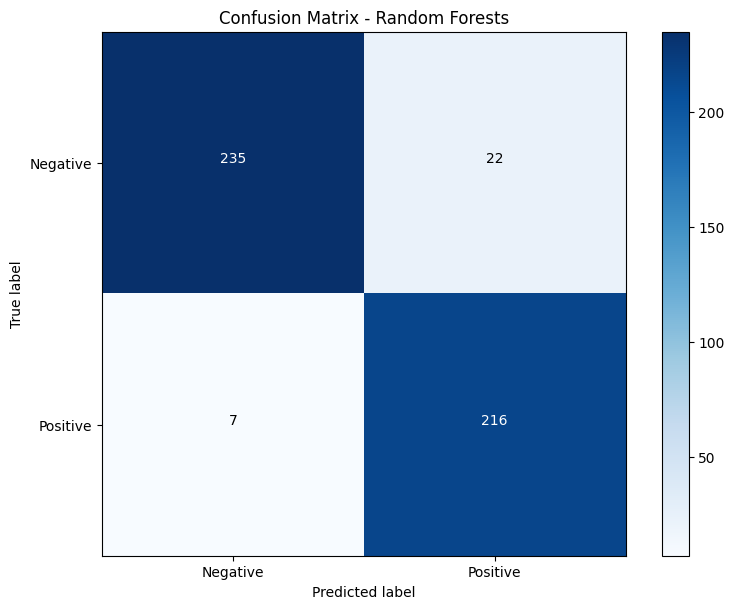

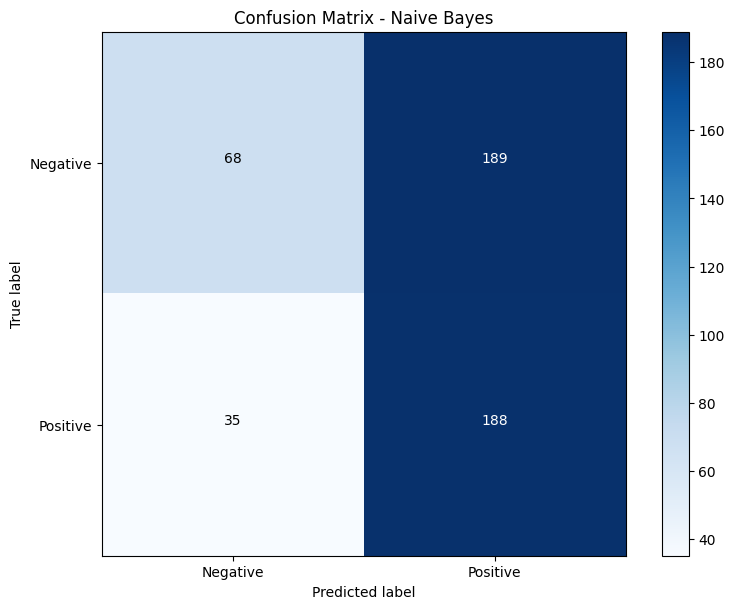

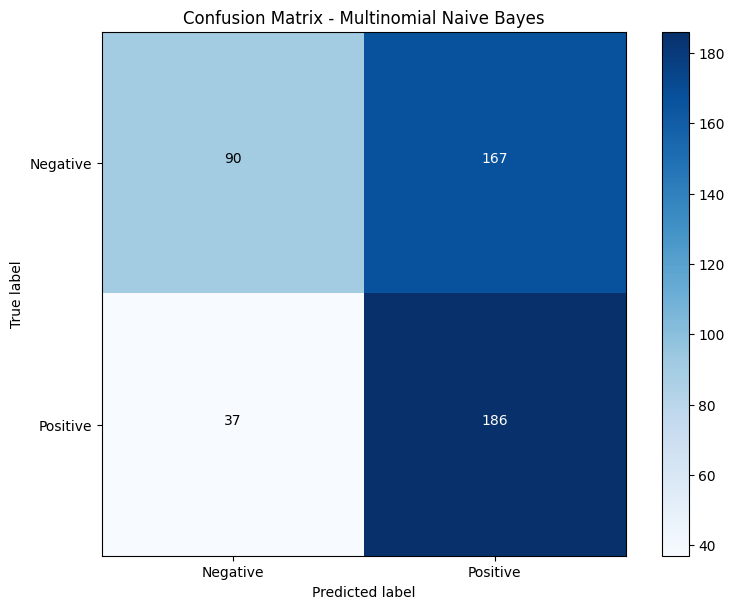

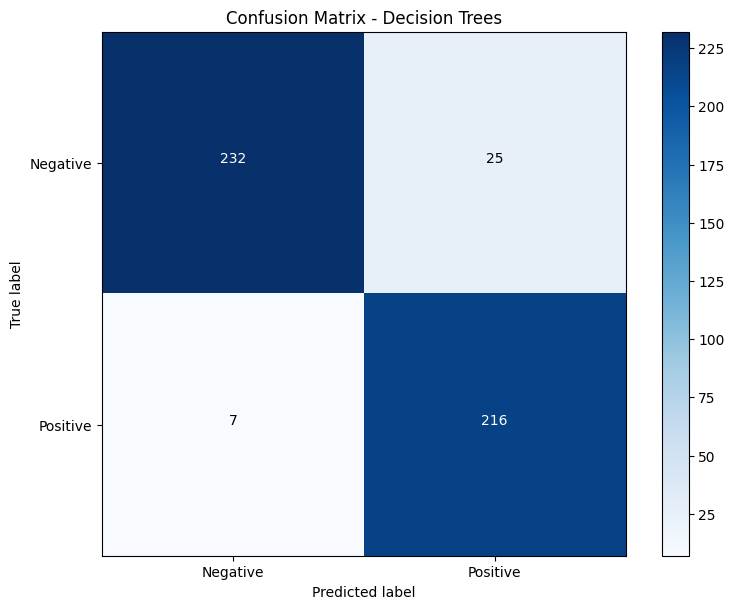

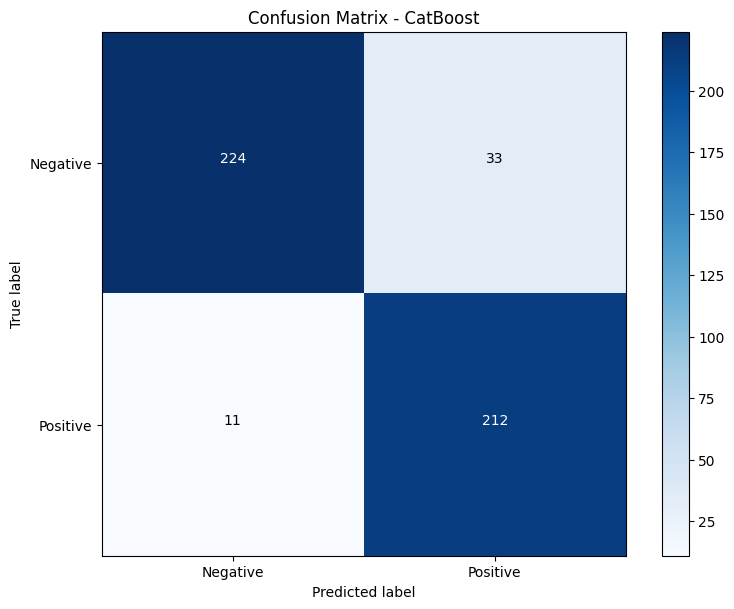

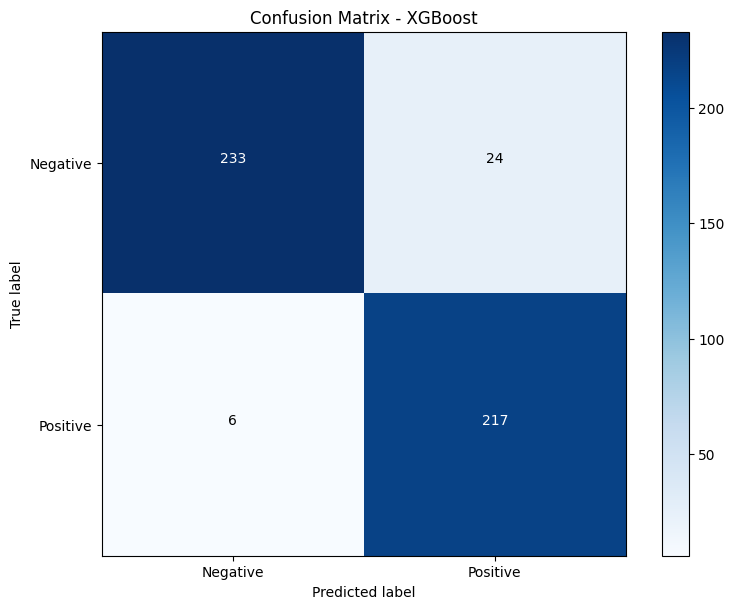

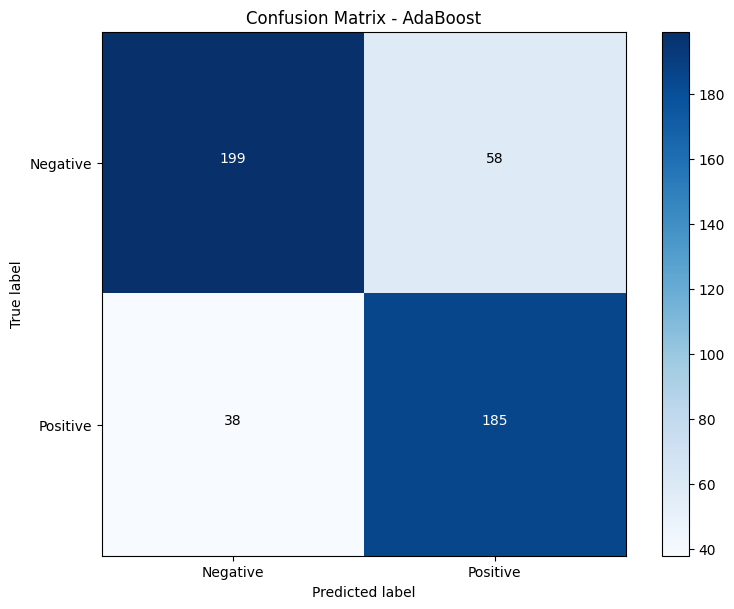

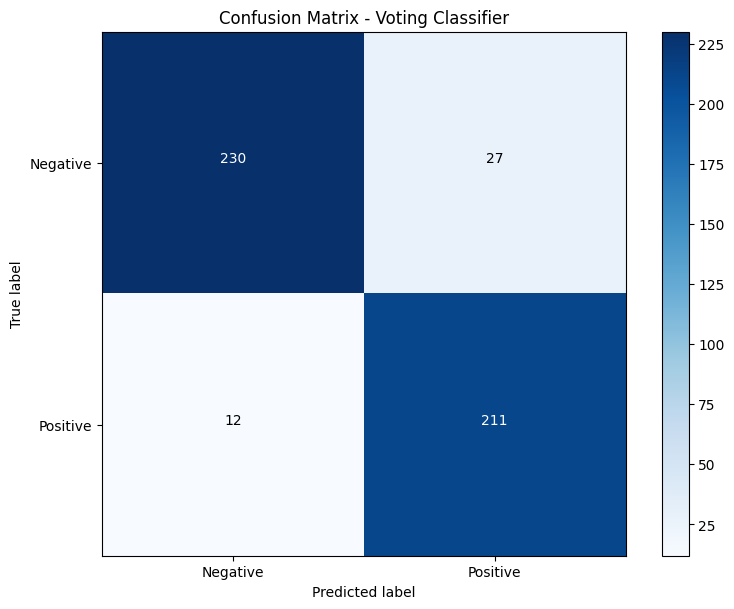

In [6]:
import os
import itertools
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pywt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

POS = '/content/drive/MyDrive/aidataset/gunshot'
NEG = '/content/drive/MyDrive/aidataset/nongunshot'
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
repeat_count = len(negatives) // len(positives)
remainder = len(negatives) % len(positives)
new_positives = positives.repeat(repeat_count)
new_positives = new_positives.concatenate(positives.take(remainder))
data = new_positives.concatenate(negatives)

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:40000]
    zero_padding = tf.zeros([40000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=5000)
data = data.batch(16)
data = data.prefetch(8)

train = data.take(130)
test = data.skip(130).take(30)
ttest = data.skip(160).take(20)

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(1241, 257, 1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer with dropout rate of 0.5
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer with dropout rate of 0.5

# Create a feature extraction model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-1].output)

# Extract features for all samples in the dataset
features = []
labels = []
for spectrogram, label in train:
    extracted_features = feature_extractor.predict(spectrogram)
    features.append(extracted_features)
    labels.append(label)

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Extract features from test set
test_features = []
test_labels = []
for spectrogram, label in test:
    extracted_features = feature_extractor.predict(spectrogram)
    test_features.append(extracted_features)
    test_labels.append(label)

test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Define classifiers
classifiers = {
    "KNN (k=2)": KNeighborsClassifier(n_neighbors=2),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "SVM": SVC(),
    "Random Forests": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Decision Trees": DecisionTreeClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False),
    "XGBoost": XGBClassifier(use_label_encoder=False, verbosity=0),
    "AdaBoost": AdaBoostClassifier(),
}

# Initialize dictionaries to store results
accuracy_results = {}
precision_results = {}
recall_results = {}
f1_results = {}
confusion_matrices = {}
train_accuracy_results = {}
test_accuracy_results = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(features, labels)
    y_pred = clf.predict(test_features)
    y_train_pred = clf.predict(features)

    # Compute evaluation metrics
    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)
    confusion = confusion_matrix(test_labels, y_pred)
    train_accuracy = accuracy_score(labels, y_train_pred)

    # Store results in dictionaries
    accuracy_results[name] = accuracy
    precision_results[name] = precision
    recall_results[name] = recall
    f1_results[name] = f1
    confusion_matrices[name] = confusion
    train_accuracy_results[name] = train_accuracy

# Ensemble methods (Voting Classifier)
voting_clf = VotingClassifier(estimators=list(classifiers.items()), voting='hard')
voting_clf.fit(features, labels)
y_pred_voting = voting_clf.predict(test_features)
y_train_pred_voting = voting_clf.predict(features)

# Compute evaluation metrics for Voting Classifier
accuracy_results['Voting Classifier'] = accuracy_score(test_labels, y_pred_voting)
precision_results['Voting Classifier'] = precision_score(test_labels, y_pred_voting)
recall_results['Voting Classifier'] = recall_score(test_labels, y_pred_voting)
f1_results['Voting Classifier'] = f1_score(test_labels, y_pred_voting)
confusion_matrices['Voting Classifier'] = confusion_matrix(test_labels, y_pred_voting)
train_accuracy_results['Voting Classifier'] = accuracy_score(labels, y_train_pred_voting)

# Print results
for name, result in accuracy_results.items():
    print(f"Classifier: {name}")
    print(f"Test Accuracy: {result}")
    print(f"Train Accuracy: {train_accuracy_results[name]}")
    print(f"Precision: {precision_results[name]}")
    print(f"Recall: {recall_results[name]}")
    print(f"F1 Score: {f1_results[name]}")
    print(f"Confusion Matrix:\n{confusion_matrices[name]}\n")

# Plot training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_results.keys(), train_accuracy_results.values(), label='Training Accuracy', marker='o')
plt.plot(accuracy_results.keys(), accuracy_results.values(), label='Test Accuracy', marker='o')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy of Different Classifiers')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 6))
plt.plot(precision_results.keys(), precision_results.values(), label='Precision')
plt.plot(recall_results.keys(), recall_results.values(), label='Recall')
plt.plot(f1_results.keys(), f1_results.values(), label='F1-score')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score of Different Classifiers')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Generate confusion matrix images
for name, confusion_matrix in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
